In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.metrics import f1_score, roc_curve, precision_recall_curve, confusion_matrix, log_loss, classification_report
import nltk
from nltk.tokenize import word_tokenize
import pandas as pd
import re
import tensorflow as tf
from imblearn.over_sampling import SMOTE
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import re

In [2]:
fake_df = pd.read_csv('data/Fake.csv')
true_df = pd.read_csv('data/True.csv')

Combining Datasets for Balance Analysis

In [3]:
fake_df['source'] = 0
true_df['source'] = 1

combined_df = pd.concat([fake_df, true_df], axis=0)
df = combined_df.sample(frac=1).reset_index(drop=True)
df = df[['text', 'title', 'source']] 
df.to_csv('data/combined.csv', index=False)
df

,text,title,source
0,This story will fade quickly to back page news...,TWO BALTIMORE POLICE OFFICERS CHARGED In Bruta...,0
1,We re not sure which of Judge Mary Murguia s q...,RADICAL LEFTIST WHO DISMISSED CHARGES AGAINST ...,0
2,WASHINGTON (Reuters) - While President Donald ...,"Despite expected U.S. troop hike, no end in si...",1
3,LONDON (Reuters) - A man accused of being part...,UK court agrees to extradite suspect in Italy ...,1
4,WASHINGTON (Reuters) - U.S. Senate Democratic ...,Schumer on Republican Obamacare repeal: it's t...,1
...,...,...,...
44893,WELLINGTON (Reuters) - New Zealand Green Party...,New Zealand Green Party leader says wants to f...,1
44894,WASHINGTON (Reuters) - U.S. Defense Secretary ...,U.S defense secretary apologizes after America...,1
44895,"Sure, we get it you trolled them teehee. Troll...",Clinton Supporter Claims Credit For Multiple ...,0
44896,WELLINGTON (Reuters) - The rising popularity o...,Minor New Zealand parties in focus as hotly co...,1


Source Assessment

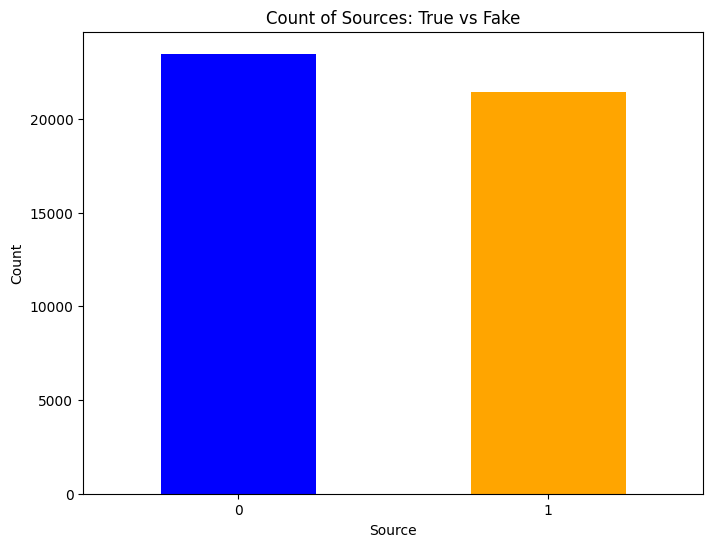

In [4]:
df.isna().sum()
df.dropna()

source_counts = df['source'].value_counts()

plt.figure(figsize=(8, 6))
source_counts.plot(kind='bar', color=['blue', 'orange'])
plt.title('Count of Sources: True vs Fake')
plt.xlabel('Source')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

Combining text and title column, these are our features

In [5]:
text = (df['title'] + df['text']).astype(str)
text

0        TWO BALTIMORE POLICE OFFICERS CHARGED In Bruta...
1        RADICAL LEFTIST WHO DISMISSED CHARGES AGAINST ...
2        Despite expected U.S. troop hike, no end in si...
3        UK court agrees to extradite suspect in Italy ...
4        Schumer on Republican Obamacare repeal: it's t...
                               ...                        
44893    New Zealand Green Party leader says wants to f...
44894    U.S defense secretary apologizes after America...
44895     Clinton Supporter Claims Credit For Multiple ...
44896    Minor New Zealand parties in focus as hotly co...
44897    Iraqi Kurdish security forces raid local broad...
Length: 44898, dtype: object

Cleaning and Lemmatizing Text

In [6]:
def clean_text(text):
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = text.lower()
    text = text.strip()
    return text

stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()
def lemmatize_stopwords(words):
    return [lemmatizer.lemmatize(word) for word in words if word.lower() not in stop_words]

tokens = text.apply(clean_text).apply(word_tokenize).apply(lemmatize_stopwords)
tokens

0        [two, baltimore, police, officer, charged, bru...
1        [radical, leftist, dismissed, charge, muslim, ...
2        [despite, expected, u, troop, hike, end, sight...
3        [uk, court, agrees, extradite, suspect, italy,...
4        [schumer, republican, obamacare, repeal, respo...
                               ...                        
44893    [new, zealand, green, party, leader, say, want...
44894    [u, defense, secretary, apologizes, american, ...
44895    [clinton, supporter, claim, credit, multiple, ...
44896    [minor, new, zealand, party, focus, hotly, con...
44897    [iraqi, kurdish, security, force, raid, local,...
Length: 44898, dtype: object

Creating Corpus

In [7]:
corpus = tokens.apply(lambda x: ' '.join(x))
corpus

0        two baltimore police officer charged brutal be...
1        radical leftist dismissed charge muslim terror...
2        despite expected u troop hike end sight afghan...
3        uk court agrees extradite suspect italy model ...
4        schumer republican obamacare repeal responsibi...
                               ...                        
44893    new zealand green party leader say want form c...
44894    u defense secretary apologizes american charge...
44895    clinton supporter claim credit multiple bernie...
44896    minor new zealand party focus hotly contested ...
44897    iraqi kurdish security force raid local broadc...
Length: 44898, dtype: object

Vectorizing (TF-IDF Vectorization)

In [8]:
vectorizer = TfidfVectorizer(use_idf=True, max_df=0.5, ngram_range=(1, 1))
tfidf = vectorizer.fit_transform(corpus)
X = tfidf
y = df['source']

#### Model Testing


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier, plot_tree

seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
print("Size of train dataset: {} rows".format(X_train.shape[0]))
print("Size of test dataset: {} rows".format(X_test.shape[0]))

Size of train dataset: 30081 rows
Size of test dataset: 14817 rows


Before SMOTE:
Training target statistics: 
 source
0    15811
1    14270
Name: count, dtype: int64

After SMOTE:
Training target statistics: 
 source
1    15811
0    15811
Name: count, dtype: int64


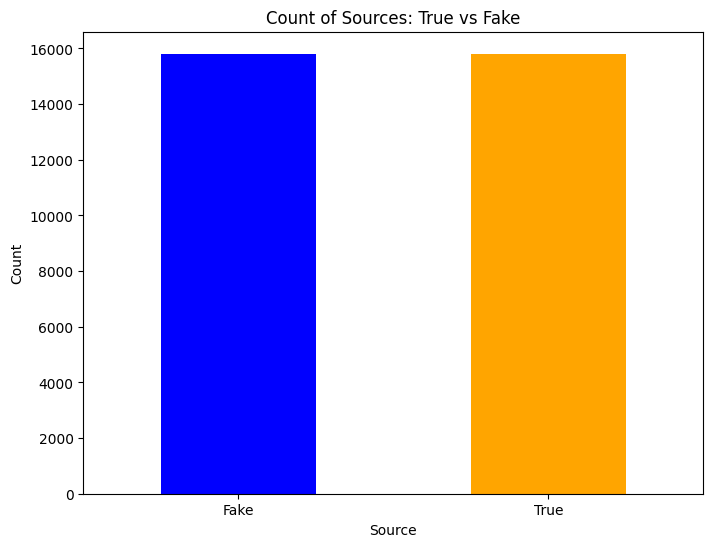

In [32]:
# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# Check the distribution after applying SMOTE
print("Before SMOTE:")
print("Training target statistics: \n", pd.Series(y_train).value_counts())

print("\nAfter SMOTE:")
print("Training target statistics: \n", pd.Series(y_train_bal).value_counts())

# Plot the balanced dataset
plt.figure(figsize=(8, 6))
pd.Series(y_train_bal).value_counts().plot(kind='bar', color=['blue', 'orange'])
plt.title('Count of Sources: True vs Fake')
plt.xlabel('Source')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Fake', 'True'], rotation=0)
plt.show()

XGB

In [11]:
model = XGBClassifier()
model.fit(X_train_bal, y_train_bal)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [12]:
y_pred_xgb = model.predict(X_test)
y_pred_proba_xgb = model.predict_proba(X_test)[:, 1]
predictions_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_xgb, 'Probability': y_pred_proba_xgb})
print(predictions_df.head())

       Actual  Predicted  Probability
25168       1          1     0.999983
5096        0          0     0.000013
3123        0          0     0.001066
37809       0          0     0.000016
27507       1          1     0.999985


In [13]:
f1 = f1_score(y_test, y_pred_xgb)
print(f"XGBoost F1 Score: {f1}")

# evaluate predictions
from sklearn.metrics import confusion_matrix
Cmat = confusion_matrix(y_test, y_pred_xgb)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print("Confusion Matrix: \n")
print(Cmat)
print("\n Accuracy: %.2f%%" % (accuracy_xgb * 100.0))

XGBoost F1 Score: 0.9981818181818182
Confusion Matrix: 

[[7654   16]
 [  10 7137]]

 Accuracy: 99.82%


Multinomial Bayes

In [14]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score, confusion_matrix, ConfusionMatrixDisplay

nb_model = MultinomialNB()
nb_model.fit(X_train_bal, y_train_bal)

MultinomialNB()

In [15]:
y_pred_nb = nb_model.predict(X_test)
y_pred_proba_nb = nb_model.predict_proba(X_test)[:, 1]
predictions_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_nb, 'Probability': y_pred_proba_nb})
print(predictions_df.head())

       Actual  Predicted  Probability
25168       1          1     0.982405
5096        0          0     0.003579
3123        0          0     0.347204
37809       0          0     0.411667
27507       1          1     0.932310


In [16]:
f1_nb = f1_score(y_test, y_pred_nb)
print(f"Multinomial Naive Bayes F1 Score: {f1_nb}")

cm_nb = confusion_matrix(y_test, y_pred_nb)
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print("Confusion Matrix: \n")
print(Cmat)
print("\n Accuracy: %.2f%%" % (accuracy_xgb * 100.0))

Multinomial Naive Bayes F1 Score: 0.9352527992210863
Confusion Matrix: 

[[7654   16]
 [  10 7137]]

 Accuracy: 99.82%


Random Forest

In [17]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=seed)
rf_model.fit(X_train_bal, y_train_bal)
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

In [18]:
predictions_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_rf, 'Probability': y_pred_proba_rf})
print(predictions_df.head())

       Actual  Predicted  Probability
25168       1          1         0.88
5096        0          0         0.15
3123        0          0         0.03
37809       0          0         0.24
27507       1          1         0.85


In [19]:
f1_rf = f1_score(y_test, y_pred_rf)
print(f"Random Forest F1 Score: {f1_rf}")

cm_nb = confusion_matrix(y_test, y_pred_rf)
accuracy_nb = accuracy_score(y_test, y_pred_rf)
print("Confusion Matrix: \n")
print(Cmat)
print("\n Accuracy: %.2f%%" % (accuracy_xgb * 100.0))

Random Forest F1 Score: 0.9894486758437565
Confusion Matrix: 

[[7654   16]
 [  10 7137]]

 Accuracy: 99.82%


Metrics (ROC and Confusion Matrix)

In [20]:
def plot_roc_curve(y_true, y_pred_proba, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name}')
    plt.legend(loc="lower right")
    plt.show()

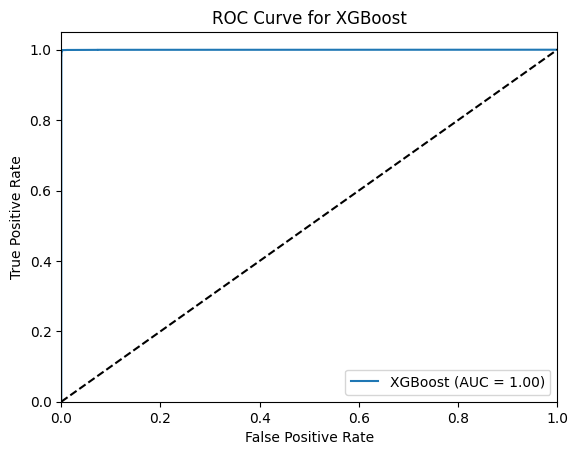

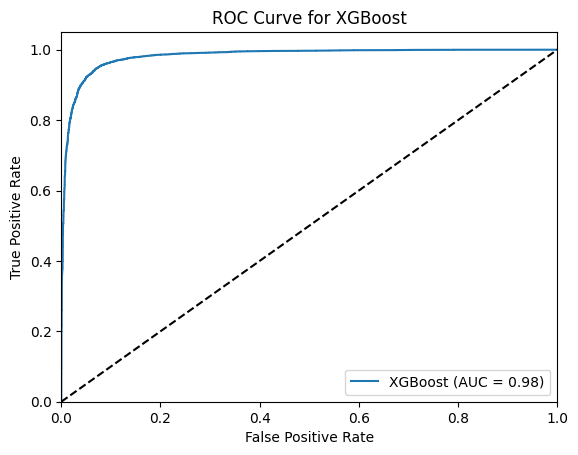

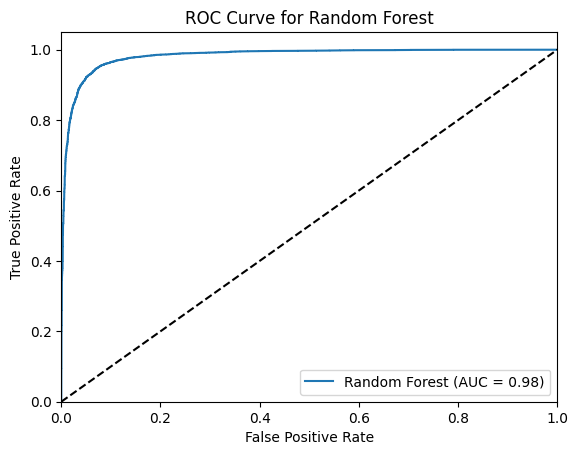

In [26]:
plot_roc_curve(y_test, y_pred_proba_xgb, "XGBoost")
plot_roc_curve(y_test, y_pred_proba_nb, "XGBoost")
plot_roc_curve(y_test, y_pred_proba_nb, "Random Forest")

Confusion Matrix For Each Model

In [22]:
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake', 'True'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

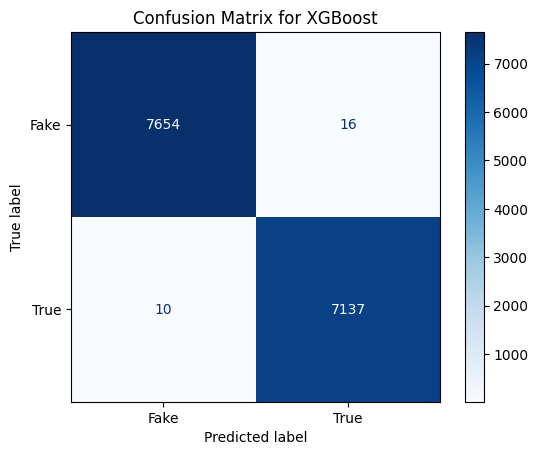

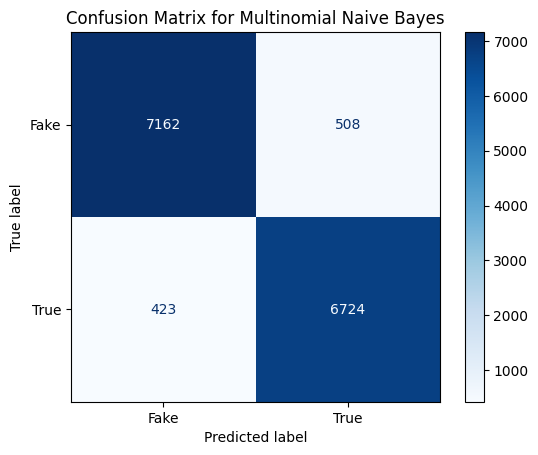

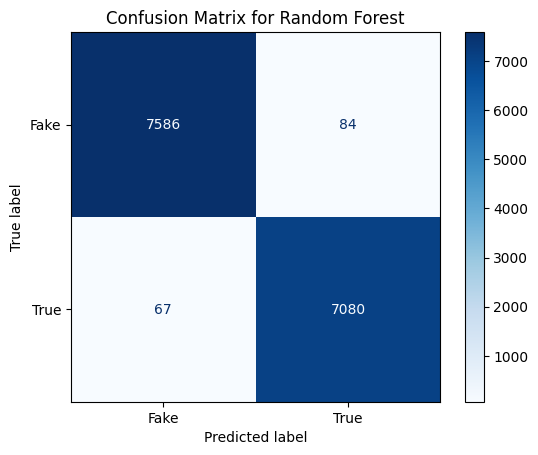

In [23]:
plot_confusion_matrix(y_test, y_pred_xgb, "XGBoost")
plot_confusion_matrix(y_test, y_pred_nb, "Multinomial Naive Bayes")
plot_confusion_matrix(y_test, y_pred_rf, "Random Forest")

Log Loss for Each Model

In [24]:
log_loss_xgb = log_loss(y_test, y_pred_proba_xgb)
print(f"XGBoost Log Loss: {log_loss_xgb:.4f}")

log_loss_nb = log_loss(y_test, y_pred_proba_nb)
print(f"Multinomial Naive Bayes Log Loss: {log_loss_nb:.4f}")

log_loss_rf = log_loss(y_test, y_pred_proba_rf)
print(f"Random Forest Log Loss: {log_loss_rf:.4f}")

XGBoost Log Loss: 0.0076
Multinomial Naive Bayes Log Loss: 0.1707
Random Forest Log Loss: 0.1815


Classification Reports (Testing/ Training Accuracy and F1 Score)

In [25]:
print("\nXGBoost Classification Report:\n")
print(classification_report(y_test, y_pred_xgb, target_names=['Fake', 'True']))
print(f"XGBoost Training Accuracy: {accuracy_xgb * 100:.2f}%")
test_accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"XGBoost Testing Accuracy: {test_accuracy_xgb * 100:.2f}%")

print("\nMultinomial Naive Bayes Classification Report:\n")
print(classification_report(y_test, y_pred_nb, target_names=['Fake', 'True']))
print(f"Multinomial Naive Bayes Training Accuracy: {accuracy_nb * 100:.2f}%")
test_accuracy_nb = accuracy_score(y_test, y_pred_nb)
print(f"Multinomial Naive Bayes Testing Accuracy: {test_accuracy_nb * 100:.2f}%")

print("\nRandom Forest Classification Report:\n")
print(classification_report(y_test, y_pred_rf, target_names=['Fake', 'True']))
print(f"Random Forest Training Accuracy: {accuracy_xgb * 100:.2f}%")
test_accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Testing Accuracy: {test_accuracy_rf * 100:.2f}%")


XGBoost Classification Report:

              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00      7670
        True       1.00      1.00      1.00      7147

    accuracy                           1.00     14817
   macro avg       1.00      1.00      1.00     14817
weighted avg       1.00      1.00      1.00     14817

XGBoost Training Accuracy: 99.82%
XGBoost Testing Accuracy: 99.82%

Multinomial Naive Bayes Classification Report:

              precision    recall  f1-score   support

        Fake       0.94      0.93      0.94      7670
        True       0.93      0.94      0.94      7147

    accuracy                           0.94     14817
   macro avg       0.94      0.94      0.94     14817
weighted avg       0.94      0.94      0.94     14817

Multinomial Naive Bayes Training Accuracy: 98.98%
Multinomial Naive Bayes Testing Accuracy: 93.72%

Random Forest Classification Report:

              precision    recall  f1-score   support

    

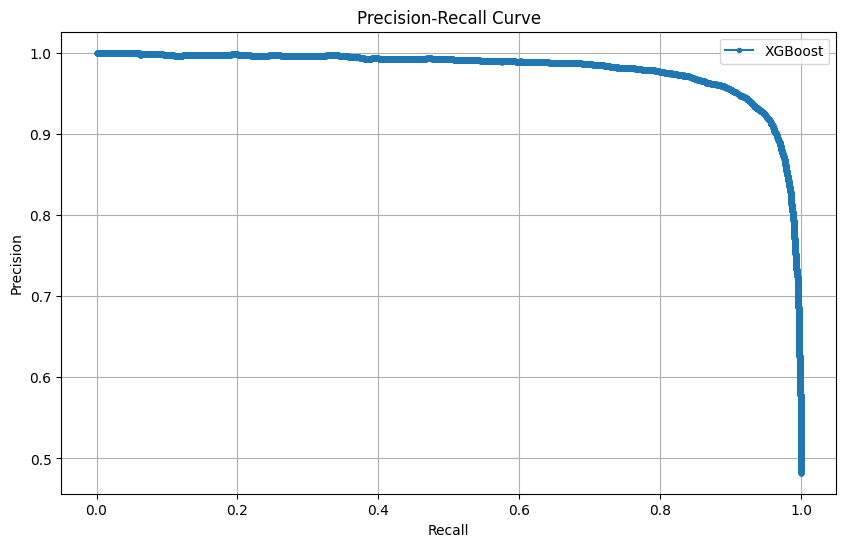

Precision at threshold 0.5: 0.93
Recall at threshold 0.5: 0.94


In [31]:
# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_nb)

# Plot the precision-recall curve
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, marker='.', label='XGBoost')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

threshold_index = (thresholds >= 0.5).argmax()  # Find the index for threshold 0.5

print(f"Precision at threshold 0.5: {precision[threshold_index]:.2f}")
print(f"Recall at threshold 0.5: {recall[threshold_index]:.2f}")